## Import datasets

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
from model_LN import *
from utils import *

## Data transformation

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(28), ], p = 0.1),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomApply(
               p=0.1
               CenterCrop(size=(28, 28))
           )
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
           )

In [6]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [7]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

## Sample image

images.shape: torch.Size([128, 3, 32, 32])


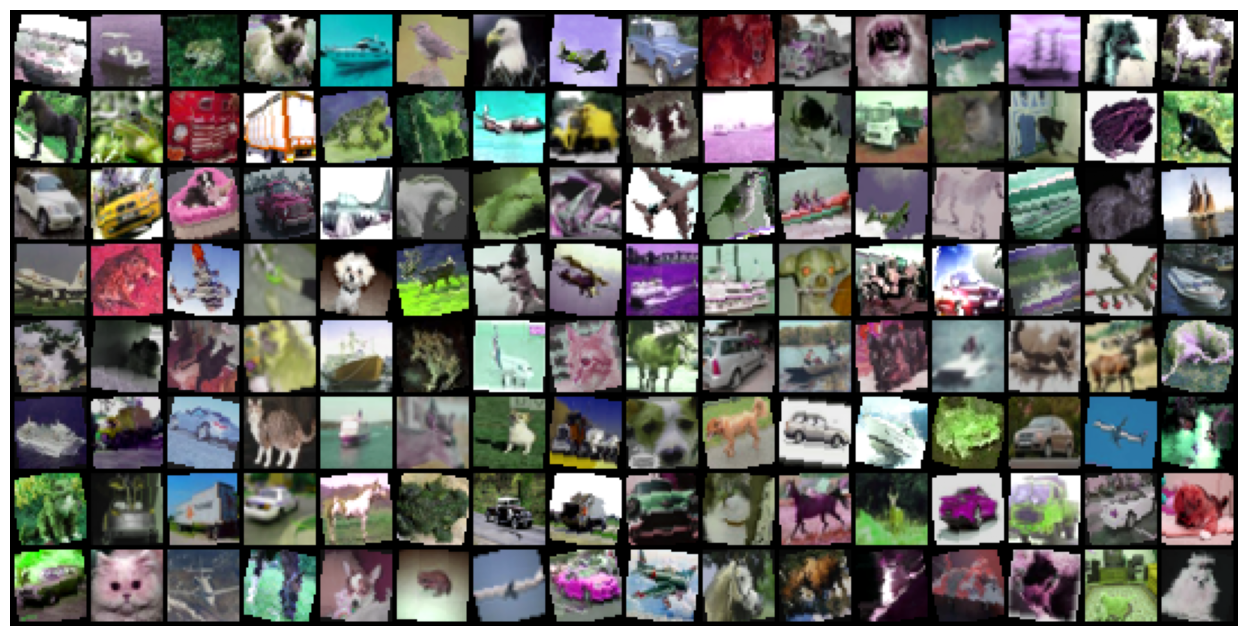

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [9]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           3,456
              ReLU-6           [-1, 24, 32, 32]               0
       BatchNorm2d-7           [-1, 24, 32, 32]              48
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
             ReLU-10            [-1, 8, 32, 32]               0
      BatchNorm2d-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.6212 Batch_id=180 Accuracy=32.68:  46%|▍| 181/391 [00:43<00:38,  5